# Individual Model Testing and Performance Comparison

This notebook loads individual trained models, tests them on the test dataset, and compares their performance using AUROC metrics to identify the best performing model for each class in the medical chest X-ray classification task.

## Overview
- **Dataset**: Chest X-ray images with 14 disease classes
- **Models**: DenseNet121, DenseNet+CBAM, EfficientNet-B2, EfficientNet-B3 
- **Evaluation**: Per-class AUROC comparison
- **Goal**: Identify best model for each disease class

## 1. Import Required Libraries and Set Configuration

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import glob
import json
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.models import densenet121, DenseNet121_Weights
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
import torchvision.transforms as transforms

from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully
PyTorch version: 2.5.1
CUDA available: True


In [2]:
CONFIG = {
    'batch_size': 8,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'data_dir': './processed_images/data',
    'models_dir': './All models',
    'results_dir': './individual_model_results',
    'seed': 42,
    'figure_size': (12, 8),
    'dpi': 100
}

DISEASE_LIST = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(CONFIG['seed'])

os.makedirs(CONFIG['results_dir'], exist_ok=True)

print("Configuration loaded")
print(f"Device: {CONFIG['device']}")
print(f"Number of disease classes: {len(DISEASE_LIST)}")

Configuration loaded
Device: cuda
Number of disease classes: 14


## 2. Load and Prepare Test Dataset

In [3]:
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def get_label_vector(labels_str):
    labels = labels_str.split('|')
    if labels == ['No Finding']:
        return [0] * len(DISEASE_LIST)
    return [1 if disease in labels else 0 for disease in DISEASE_LIST]

class CheXNetDataset(Dataset):
    def __init__(self, df, image_to_folder, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_to_folder = image_to_folder
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['Image Index']
        folder = self.image_to_folder[img_name]
        img_path = os.path.join(folder, img_name)
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        labels = torch.tensor(get_label_vector(row['Finding Labels']), dtype=torch.float)
        
        return image, labels

In [4]:
data_path = CONFIG['data_dir']
csv_file = os.path.join(data_path, 'Data_Entry_2017.csv')

df = pd.read_csv(csv_file)
print(f"Original dataset size: {len(df)} samples")

image_folders = [os.path.join(data_path, f'images_{str(i).zfill(3)}', 'images') for i in range(1, 13)]
image_to_folder = {}

for folder in image_folders:
    if os.path.exists(folder):
        for filename in os.listdir(folder):
            if filename.endswith('.png'):
                image_to_folder[filename] = folder

df = df[df['Image Index'].isin(image_to_folder.keys())].reset_index(drop=True)
print(f"Filtered dataset size: {len(df)} samples")

unique_patients = df['Patient ID'].unique()

train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.02, random_state=CONFIG['seed']
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.052, random_state=CONFIG['seed']
)

test_df = df[df['Patient ID'].isin(test_patients)].reset_index(drop=True)
print(f"Test dataset size: {len(test_df)} samples")

print("\nTest set label distribution:")
for i, disease in enumerate(DISEASE_LIST):
    test_labels = [get_label_vector(row['Finding Labels']) for _, row in test_df.iterrows()]
    positive_count = sum([labels[i] for labels in test_labels])
    percentage = (positive_count / len(test_df)) * 100
    print(f"{disease}: {positive_count}/{len(test_df)} ({percentage:.1f}%)")

Original dataset size: 112120 samples
Filtered dataset size: 112120 samples
Test dataset size: 2299 samples

Test set label distribution:
Atelectasis: 226/2299 (9.8%)
Filtered dataset size: 112120 samples
Test dataset size: 2299 samples

Test set label distribution:
Atelectasis: 226/2299 (9.8%)
Cardiomegaly: 118/2299 (5.1%)
Consolidation: 100/2299 (4.3%)
Cardiomegaly: 118/2299 (5.1%)
Consolidation: 100/2299 (4.3%)
Edema: 52/2299 (2.3%)
Effusion: 339/2299 (14.7%)
Emphysema: 61/2299 (2.7%)
Fibrosis: 37/2299 (1.6%)
Hernia: 9/2299 (0.4%)
Edema: 52/2299 (2.3%)
Effusion: 339/2299 (14.7%)
Emphysema: 61/2299 (2.7%)
Fibrosis: 37/2299 (1.6%)
Hernia: 9/2299 (0.4%)
Infiltration: 395/2299 (17.2%)
Mass: 117/2299 (5.1%)
Nodule: 141/2299 (6.1%)
Pleural_Thickening: 94/2299 (4.1%)
Pneumonia: 29/2299 (1.3%)
Pneumothorax: 93/2299 (4.0%)
Infiltration: 395/2299 (17.2%)
Mass: 117/2299 (5.1%)
Nodule: 141/2299 (6.1%)
Pleural_Thickening: 94/2299 (4.1%)
Pneumonia: 29/2299 (1.3%)
Pneumothorax: 93/2299 (4.0%)


In [5]:
test_dataset = CheXNetDataset(test_df, image_to_folder, transform=transform_test)
test_loader = DataLoader(
    test_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False, 
    num_workers=0
)

print(f"Test DataLoader created with {len(test_loader)} batches")

sample_batch = next(iter(test_loader))
images, labels = sample_batch
print(f"Sample batch - Images: {images.shape}, Labels: {labels.shape}")

Test DataLoader created with 288 batches
Sample batch - Images: torch.Size([8, 3, 224, 224]), Labels: torch.Size([8, 14])


## 3. Define Model Architectures

In [6]:
def create_densenet_model():
    model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
    model.classifier = nn.Linear(model.classifier.in_features, 14)
    return model

def create_efficientnet_b2_model():
    model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
    num_features = model.classifier[1].in_features
    model.classifier = nn.Linear(num_features, 14)
    return model

def create_efficientnet_b3_model():
    model = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
    num_features = model.classifier[1].in_features
    model.classifier = nn.Linear(num_features, 14)
    return model

In [7]:
def create_densenet_attention_model():
    
    class ChannelAttention(nn.Module):
        def __init__(self, in_planes, ratio=16):
            super(ChannelAttention, self).__init__()
            self.avg_pool = nn.AdaptiveAvgPool2d(1)
            self.max_pool = nn.AdaptiveMaxPool2d(1)
            self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
            self.relu1 = nn.ReLU()
            self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
            self.sigmoid = nn.Sigmoid()
            
        def forward(self, x):
            avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
            max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
            out = avg_out + max_out
            return self.sigmoid(out)

    class SpatialAttention(nn.Module):
        def __init__(self, kernel_size=7):
            super(SpatialAttention, self).__init__()
            self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
            self.sigmoid = nn.Sigmoid()
            
        def forward(self, x):
            avg_out = torch.mean(x, dim=1, keepdim=True)
            max_out, _ = torch.max(x, dim=1, keepdim=True)
            x = torch.cat([avg_out, max_out], dim=1)
            x = self.conv1(x)
            return self.sigmoid(x)

    class CBAM(nn.Module):
        def __init__(self, in_planes, ratio=16, kernel_size=7):
            super(CBAM, self).__init__()
            self.ca = ChannelAttention(in_planes, ratio)
            self.sa = SpatialAttention(kernel_size)
            
        def forward(self, x):
            x = x * self.ca(x)
            x = x * self.sa(x)
            return x

    class DenseNetCBAM(nn.Module):
        def __init__(self, num_classes=14):
            super(DenseNetCBAM, self).__init__()
            self.densenet = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
            num_features = self.densenet.classifier.in_features
            self.densenet.classifier = nn.Identity()
            self.attention = CBAM(num_features)
            self.global_pool = nn.AdaptiveAvgPool2d(1)
            self.dropout = nn.Dropout(0.2)
            self.classifier = nn.Linear(num_features, num_classes)
            
        def forward(self, x):
            features = self.densenet.features(x)
            attended_features = self.attention(features)
            pooled = self.global_pool(attended_features)
            pooled = pooled.view(pooled.size(0), -1)
            output = self.dropout(pooled)
            output = self.classifier(output)
            return output
    
    return DenseNetCBAM()

## 4. Model Detection and Loading System

In [8]:
def detect_efficientnet_variant(checkpoint_path):
    try:
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        state_dict = checkpoint.get('state_dict', checkpoint)
        
        first_conv_key = 'features.0.0.weight'
        if first_conv_key in state_dict:
            out_channels = state_dict[first_conv_key].shape[0]
            
            variant_map = {
                32: 'efficientnet_b2',
                40: 'efficientnet_b3',
                48: 'efficientnet_b4',
            }
            
            return variant_map.get(out_channels, f'efficientnet_unknown_{out_channels}')
        
        return 'not_efficientnet'
    except Exception as e:
        return 'error'

def detect_model_architecture(model_path):
    try:
        state_dict = torch.load(model_path, map_location='cpu')
        state_dict = state_dict.get('state_dict', state_dict)
        
        attention_keys = ['attention.ca.fc1.weight', 'attention.ca.fc2.weight', 'attention.sa.conv1.weight']
        densenet_prefixed_keys = ['densenet.features.conv0.weight', 'densenet.features.norm0.weight']
        if all(key in state_dict for key in attention_keys) and any(key in state_dict for key in densenet_prefixed_keys):
            return 'densenet_attention'
        
        densenet_keys = ['features.conv0.weight', 'features.denseblock1.denselayer1.norm1.weight']
        if all(key in state_dict for key in densenet_keys):
            return 'densenet'
        
        efficientnet_keys = ['features.0.0.weight', 'features.1.0.block.0.0.weight']
        if any(key in state_dict for key in efficientnet_keys):
            variant = detect_efficientnet_variant(model_path)
            return variant if variant in ['efficientnet_b2', 'efficientnet_b3'] else 'efficientnet_unknown'
        
        return 'unknown'
    except Exception as e:
        return 'unknown'

In [9]:
def load_state_dict_flexible(model, checkpoint_path, device='cpu'):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    state_dict = checkpoint.get('state_dict', checkpoint)
    
    model_state = model.state_dict()
    loaded_keys = []
    skipped_missing = []
    skipped_shape = []

    for key, value in state_dict.items():
        if key in model_state:
            if model_state[key].shape == value.shape:
                model_state[key] = value
                loaded_keys.append(key)
            else:
                skipped_shape.append((key, value.shape, model_state[key].shape))
        else:
            skipped_missing.append(key)

    model.load_state_dict(model_state)

    return {
        'loaded_keys': loaded_keys,
        'skipped_missing': skipped_missing,
        'skipped_shape': skipped_shape,
        'success': len(loaded_keys) > 0
    }

def load_individual_model(model_path, device='cpu'):
    model_name = os.path.basename(model_path)
    print(f"Loading {model_name}")
    
    architecture = detect_model_architecture(model_path)
    
    if architecture == 'densenet':
        model = create_densenet_model()
        arch_name = 'DenseNet121'
    elif architecture == 'densenet_attention':
        model = create_densenet_attention_model()
        arch_name = 'DenseNet121+CBAM'
    elif architecture == 'efficientnet_b2':
        model = create_efficientnet_b2_model()
        arch_name = 'EfficientNet-B2'
    elif architecture == 'efficientnet_b3':
        model = create_efficientnet_b3_model()
        arch_name = 'EfficientNet-B3'
    else:
        print(f"Unknown architecture: {architecture}")
        return None, None
    
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        load_info = {'method': 'strict', 'success': True}
    except Exception as e:
        load_info = load_state_dict_flexible(model, model_path, device)
        if not load_info['success']:
            return None, None
    
    model.to(device)
    model.eval()
    
    metadata = {
        'filename': model_name,
        'architecture': architecture,
        'arch_name': arch_name,
        'device': device,
        'load_info': load_info
    }
    
    return model, metadata

In [10]:
model_paths = glob.glob(os.path.join(CONFIG['models_dir'], '*.pth'))
print(f"Found {len(model_paths)} model files")

loaded_models = []
model_metadata = []

for model_path in model_paths:
    model, metadata = load_individual_model(model_path, CONFIG['device'])
    if model is not None:
        loaded_models.append(model)
        model_metadata.append(metadata)

print(f"Successfully loaded {len(loaded_models)} models")

if loaded_models:
    print("\nLoaded Models:")
    for i, metadata in enumerate(model_metadata):
        print(f"{i+1}. {metadata['filename']} - {metadata['arch_name']}")
else:
    print("No models were successfully loaded")

Found 14 model files
Loading seed 12-densnet121.pth
Loading seed 22 - densnet121.pth
Loading seed 22 - densnet121.pth
Loading seed 22 - efficienet b3.pth
Loading seed 22 - efficienet b3.pth
Loading seed 22 - efficinet b2.pth
Loading seed 22 - efficinet b2.pth
Loading seed 22 - ZLPR loss.pth
Loading seed 22 - ZLPR loss.pth
Loading seed 32 - efficienet b3.pth
Loading seed 32 - efficienet b3.pth
Loading seed 32 - efficinet b2.pth
Loading seed 32 - efficinet b2.pth
Loading seed 32 - ZLPR loss.pth
Loading seed 32 - ZLPR loss.pth
Loading seed 32- densnet121.pth
Loading seed 32- densnet121.pth
Loading seed 42 - densnet121- Attention.pth
Loading seed 42 - densnet121- Attention.pth
Loading seed 42 - efficienet b3.pth
Loading seed 42 - efficienet b3.pth
Loading seed 42 - efficinet b2.pth
Loading seed 42 - efficinet b2.pth
Loading seed 42 - ZLPR loss.pth
Loading seed 42 - ZLPR loss.pth
Loading seed 42- densnet 121.pth
Loading seed 42- densnet 121.pth
Successfully loaded 14 models

Loaded Models:


## 5. Individual Model Evaluation

In [11]:
def evaluate_single_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            outputs = model(images)
            predictions = torch.sigmoid(outputs).cpu()
            
            all_predictions.append(predictions)
            all_labels.append(labels)
    
    predictions = torch.cat(all_predictions, dim=0).numpy()
    labels = torch.cat(all_labels, dim=0).numpy()
    
    return predictions, labels

def calculate_metrics(labels, predictions):
    results = {}
    
    for i, disease in enumerate(DISEASE_LIST):
        try:
            auc = roc_auc_score(labels[:, i], predictions[:, i])
        except ValueError:
            auc = 0.0
        
        results[disease] = {
            'auroc': auc,
            'positive_samples': int(labels[:, i].sum()),
            'total_samples': len(labels)
        }
    
    avg_auroc = np.mean([results[disease]['auroc'] for disease in DISEASE_LIST])
    results['average'] = {'auroc': avg_auroc}
    
    return results

In [12]:
model_results = []

print("Evaluating individual models on test dataset")

for i, (model, metadata) in enumerate(zip(loaded_models, model_metadata)):
    print(f"\nEvaluating {i+1}/{len(loaded_models)}: {metadata['filename']}")
    
    predictions, labels = evaluate_single_model(model, test_loader, CONFIG['device'])
    
    metrics = calculate_metrics(labels, predictions)
    
    result = {
        'model_name': metadata['filename'],
        'architecture': metadata['arch_name'],
        'metrics': metrics,
        'predictions': predictions
    }
    
    model_results.append(result)
    
    print(f"Average AUROC: {metrics['average']['auroc']:.4f}")

print(f"\nCompleted evaluation of {len(model_results)} models")

Evaluating individual models on test dataset

Evaluating 1/14: seed 12-densnet121.pth


Evaluating: 100%|██████████| 288/288 [00:48<00:00,  5.96it/s]



Average AUROC: 0.8442

Evaluating 2/14: seed 22 - densnet121.pth


Evaluating: 100%|██████████| 288/288 [00:42<00:00,  6.70it/s]



Average AUROC: 0.8475

Evaluating 3/14: seed 22 - efficienet b3.pth


Evaluating: 100%|██████████| 288/288 [00:43<00:00,  6.63it/s]



Average AUROC: 0.8078

Evaluating 4/14: seed 22 - efficinet b2.pth


Evaluating: 100%|██████████| 288/288 [00:43<00:00,  6.55it/s]



Average AUROC: 0.8277

Evaluating 5/14: seed 22 - ZLPR loss.pth


Evaluating: 100%|██████████| 288/288 [00:43<00:00,  6.66it/s]



Average AUROC: 0.8468

Evaluating 6/14: seed 32 - efficienet b3.pth


Evaluating: 100%|██████████| 288/288 [00:42<00:00,  6.78it/s]


Average AUROC: 0.8112

Evaluating 7/14: seed 32 - efficinet b2.pth


Evaluating: 100%|██████████| 288/288 [00:42<00:00,  6.71it/s]



Average AUROC: 0.8250

Evaluating 8/14: seed 32 - ZLPR loss.pth


Evaluating: 100%|██████████| 288/288 [00:44<00:00,  6.54it/s]



Average AUROC: 0.8479

Evaluating 9/14: seed 32- densnet121.pth


Evaluating: 100%|██████████| 288/288 [00:43<00:00,  6.65it/s]



Average AUROC: 0.8458

Evaluating 10/14: seed 42 - densnet121- Attention.pth


Evaluating: 100%|██████████| 288/288 [00:43<00:00,  6.61it/s]


Average AUROC: 0.8480

Evaluating 11/14: seed 42 - efficienet b3.pth


Evaluating: 100%|██████████| 288/288 [00:42<00:00,  6.78it/s]


Average AUROC: 0.8117

Evaluating 12/14: seed 42 - efficinet b2.pth


Evaluating: 100%|██████████| 288/288 [00:42<00:00,  6.75it/s]



Average AUROC: 0.8322

Evaluating 13/14: seed 42 - ZLPR loss.pth


Evaluating: 100%|██████████| 288/288 [00:43<00:00,  6.69it/s]


Average AUROC: 0.8462

Evaluating 14/14: seed 42- densnet 121.pth


Evaluating: 100%|██████████| 288/288 [00:43<00:00,  6.60it/s]

Average AUROC: 0.8514

Completed evaluation of 14 models


## 6. Model Performance Comparison

In [13]:
comparison_data = []

for result in model_results:
    model_name = result['model_name']
    architecture = result['architecture']
    
    row = {'Model': model_name, 'Architecture': architecture}
    row['Average'] = result['metrics']['average']['auroc']  # Add Average right after Architecture
    
    for disease in DISEASE_LIST:
        auroc = result['metrics'][disease]['auroc']
        row[disease] = auroc
    
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

# Reorder columns: Model, Architecture, Average, then diseases
cols = ['Model', 'Architecture', 'Average'] + DISEASE_LIST
comparison_df = comparison_df[cols]

print("Model Performance Comparison (AUROC Scores)")
print("=" * 80)
print(comparison_df.round(4).to_string(index=False))


Model Performance Comparison (AUROC Scores)
                              Model     Architecture  Average  Atelectasis  Cardiomegaly  Consolidation  Edema  Effusion  Emphysema  Fibrosis  Hernia  Infiltration   Mass  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax
             seed 12-densnet121.pth      DenseNet121   0.8442       0.8047        0.9320         0.7927 0.8841    0.9010     0.9640    0.8262  0.9902        0.6975 0.9026  0.7666              0.8019     0.6726        0.8831
           seed 22 - densnet121.pth      DenseNet121   0.8475       0.8129        0.9388         0.7773 0.8991    0.8993     0.9681    0.8441  0.9802        0.6970 0.8984  0.7757              0.8002     0.6974        0.8761
        seed 22 - efficienet b3.pth  EfficientNet-B3   0.8078       0.7976        0.9226         0.7568 0.8568    0.8948     0.9183    0.6911  0.9302        0.6817 0.8654  0.7030              0.7327     0.7130        0.8447
         seed 22 - efficinet b2.pth  EfficientNet-B2   0.827

In [14]:
best_models_per_class = {}

for disease in DISEASE_LIST:
    best_auroc = 0
    best_model = None
    
    for result in model_results:
        auroc = result['metrics'][disease]['auroc']
        if auroc > best_auroc:
            best_auroc = auroc
            best_model = result['model_name']
    
    best_models_per_class[disease] = {
        'model': best_model,
        'auroc': best_auroc
    }

print("\nBest Model for Each Disease Class:")
print("=" * 50)
for disease, info in best_models_per_class.items():
    print(f"{disease:<20}: {info['model']:<30} (AUROC: {info['auroc']:.4f})")


Best Model for Each Disease Class:
Atelectasis         : seed 32- densnet121.pth        (AUROC: 0.8187)
Cardiomegaly        : seed 32- densnet121.pth        (AUROC: 0.9406)
Consolidation       : seed 12-densnet121.pth         (AUROC: 0.7927)
Edema               : seed 22 - densnet121.pth       (AUROC: 0.8991)
Effusion            : seed 32 - ZLPR loss.pth        (AUROC: 0.9024)
Emphysema           : seed 22 - densnet121.pth       (AUROC: 0.9681)
Fibrosis            : seed 42 - ZLPR loss.pth        (AUROC: 0.8564)
Hernia              : seed 42 - densnet121- Attention.pth (AUROC: 0.9973)
Infiltration        : seed 32 - ZLPR loss.pth        (AUROC: 0.7069)
Mass                : seed 42- densnet 121.pth       (AUROC: 0.9122)
Nodule              : seed 42- densnet 121.pth       (AUROC: 0.7780)
Pleural_Thickening  : seed 42- densnet 121.pth       (AUROC: 0.8124)
Pneumonia           : seed 32- densnet121.pth        (AUROC: 0.7243)
Pneumothorax        : seed 42- densnet 121.pth       (AUROC: 0

## 7. Performance Visualization

In [15]:
# Display best performed models as a ranking
ranking_df = comparison_df[['Model', 'Average']].copy()
ranking_df = ranking_df.sort_values(by='Average', ascending=False).reset_index(drop=True)
ranking_df.index = ranking_df.index + 1  # Start rank from 1
ranking_df.insert(0, 'Rank', ranking_df.index)

print("Best Performed Models Ranking")
print("=" * 40)
print(ranking_df.rename(columns={'Average': 'avg auroc'}).to_string(index=False))


Best Performed Models Ranking
 Rank                               Model  avg auroc
    1            seed 42- densnet 121.pth   0.851406
    2 seed 42 - densnet121- Attention.pth   0.848026
    3             seed 32 - ZLPR loss.pth   0.847912
    4            seed 22 - densnet121.pth   0.847459
    5             seed 22 - ZLPR loss.pth   0.846752
    6             seed 42 - ZLPR loss.pth   0.846185
    7             seed 32- densnet121.pth   0.845796
    8              seed 12-densnet121.pth   0.844242
    9          seed 42 - efficinet b2.pth   0.832160
   10          seed 22 - efficinet b2.pth   0.827676
   11          seed 32 - efficinet b2.pth   0.825004
   12         seed 42 - efficienet b3.pth   0.811675
   13         seed 32 - efficienet b3.pth   0.811151
   14         seed 22 - efficienet b3.pth   0.807760


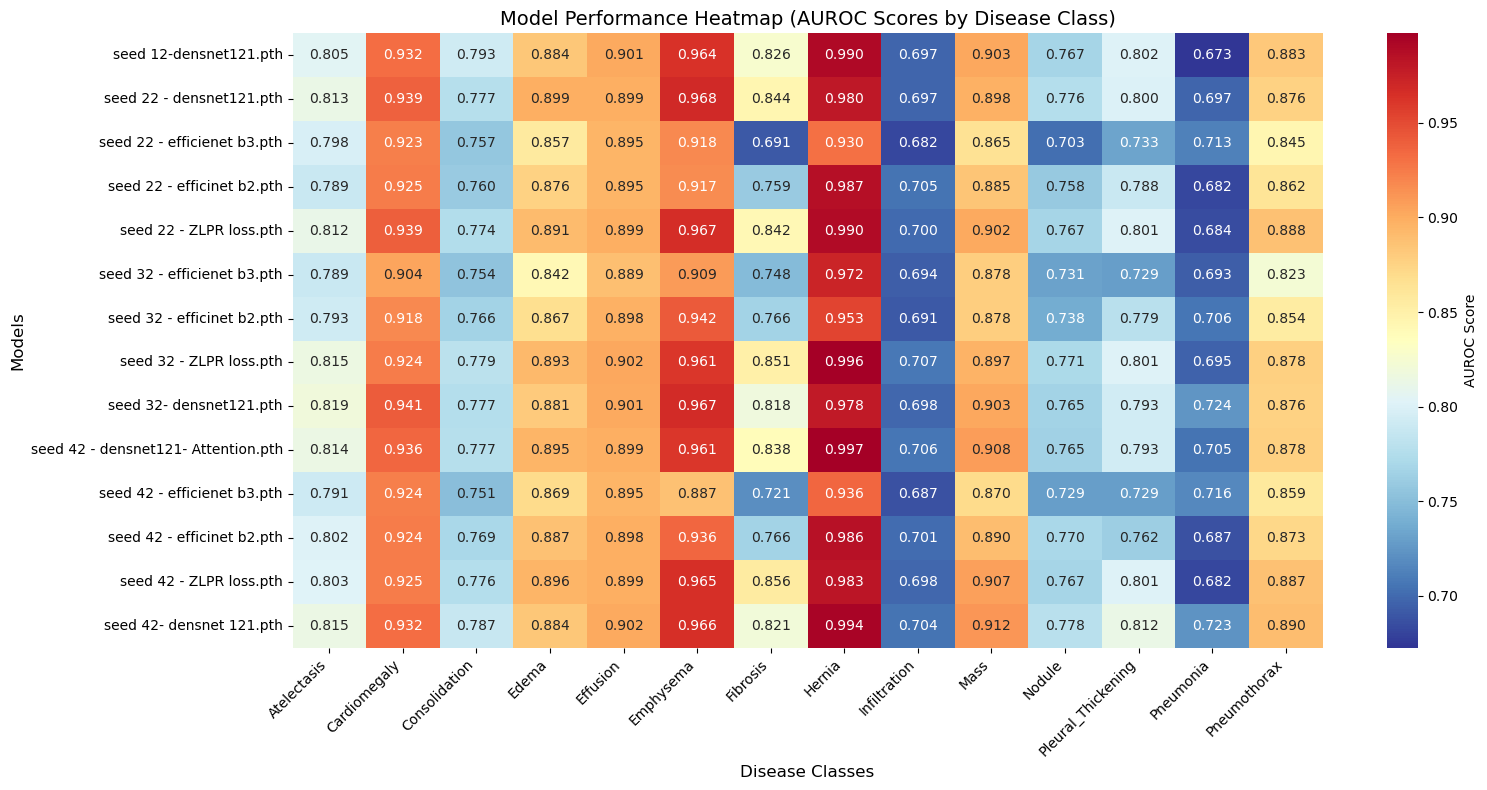

In [16]:
auroc_matrix = comparison_df.set_index('Model')[DISEASE_LIST].values

plt.figure(figsize=(16, 8))
sns.heatmap(auroc_matrix, 
            xticklabels=DISEASE_LIST, 
            yticklabels=comparison_df['Model'],
            annot=True, 
            fmt='.3f', 
            cmap='RdYlBu_r',
            cbar_kws={'label': 'AUROC Score'})
plt.title('Model Performance Heatmap (AUROC Scores by Disease Class)', fontsize=14)
plt.xlabel('Disease Classes', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

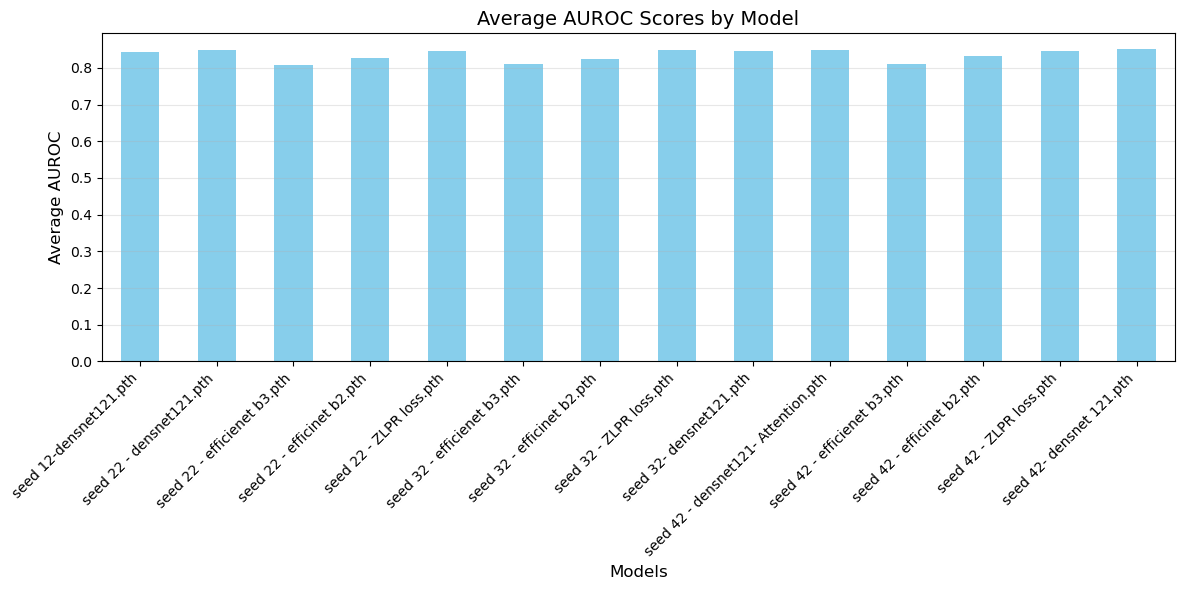

In [17]:
plt.figure(figsize=(12, 6))
comparison_df.set_index('Model')['Average'].plot(kind='bar', color='skyblue')
plt.title('Average AUROC Scores by Model', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Average AUROC', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Results Summary

In [18]:
print("\nFINAL SUMMARY")
print("=" * 60)

print(f"Total models evaluated: {len(model_results)}")
print(f"Test dataset size: {len(test_df)} samples")
print(f"Number of disease classes: {len(DISEASE_LIST)}")

print("\nTop performing models by average AUROC:")
top_models = comparison_df.nlargest(3, 'Average')[['Model', 'Architecture', 'Average']]
for idx, row in top_models.iterrows():
    print(f"{row['Model']:<30} ({row['Architecture']:<20}) - {row['Average']:.4f}")

print("\nBest models per disease class:")
for disease, info in best_models_per_class.items():
    if info['auroc'] > 0:
        print(f"{disease:<20}: {info['model']:<30} (AUROC: {info['auroc']:.4f})")


FINAL SUMMARY
Total models evaluated: 14
Test dataset size: 2299 samples
Number of disease classes: 14

Top performing models by average AUROC:
seed 42- densnet 121.pth       (DenseNet121         ) - 0.8514
seed 42 - densnet121- Attention.pth (DenseNet121+CBAM    ) - 0.8480
seed 32 - ZLPR loss.pth        (DenseNet121         ) - 0.8479

Best models per disease class:
Atelectasis         : seed 32- densnet121.pth        (AUROC: 0.8187)
Cardiomegaly        : seed 32- densnet121.pth        (AUROC: 0.9406)
Consolidation       : seed 12-densnet121.pth         (AUROC: 0.7927)
Edema               : seed 22 - densnet121.pth       (AUROC: 0.8991)
Effusion            : seed 32 - ZLPR loss.pth        (AUROC: 0.9024)
Emphysema           : seed 22 - densnet121.pth       (AUROC: 0.9681)
Fibrosis            : seed 42 - ZLPR loss.pth        (AUROC: 0.8564)
Hernia              : seed 42 - densnet121- Attention.pth (AUROC: 0.9973)
Infiltration        : seed 32 - ZLPR loss.pth        (AUROC: 0.7069)
Mas